In [4]:
%%javascript
// disable scroll
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// from https://stackoverflow.com/questions/36757301/disable-ipython-notebook-autoscrolling

<IPython.core.display.Javascript object>

In [5]:
import simpy
from __future__ import division

## Simpy tutorial

### Generator statements

In [2]:
def range_(n):
    i = 0
    while i < n:
        yield i
        i += 1

In [3]:
for value in range_(10):
    print(value)

0
1
2
3
4
5
6
7
8
9


In [4]:
x = range_(10)
print(x)

<generator object range_ at 0x10ebece10>


In [5]:
print(next(x))

0


### Simpy basics

In [6]:
def car(env):
    while True:
        print('Start parking at %d' % env.now)
        parking_duration = 5
        yield env.timeout(parking_duration)
        print('Start driving at %d' % env.now)
        trip_duration = 2
        yield env.timeout(trip_duration)

In [7]:
env = simpy.Environment()
env.process(car(env))
env.run(until=15)

Start parking at 0
Start driving at 5
Start parking at 7
Start driving at 12
Start parking at 14


### In classes

In [8]:
class Car(object):
    def __init__(self, env):
        self.env = env
        self.action = env.process(self.run())
        
    def run(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            # We may get interrupted while charging the battery
            try:
                yield self.env.process(self.charge(charge_duration))
            except simpy.Interrupt:
                # When we received an interrupt, we stop charging and
                # switch to the "driving" state
                print('Was interrupted. Hope, the battery is full enough ...')

            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def charge(self, duration):
            yield self.env.timeout(duration)

In [9]:
def driver(env, car):
    yield env.timeout(3)
    car.action.interrupt()

In [10]:
env = simpy.Environment()
car = Car(env)
env.process(driver(env,car))
env.run(until=15)

Start parking and charging at 0
Was interrupted. Hope, the battery is full enough ...
Start driving at 3
Start parking and charging at 5
Start driving at 10
Start parking and charging at 12


### Resources/Servers

In [11]:
def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to the BCS
    yield env.timeout(driving_time)

    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with bcs.request() as req:
        yield req
        # Charge the battery
        print('%s starting to charge at %s' % (name, env.now))
        yield env.timeout(charge_duration)
        print('%s leaving the bcs at %s' % (name, env.now))

In [12]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)
for i in range(4):
    env.process(car(env, 'Car %d' % i, bcs, i*2, 5))
env.run()

Car 0 arriving at 0
Car 0 starting to charge at 0
Car 1 arriving at 2
Car 1 starting to charge at 2
Car 2 arriving at 4
Car 0 leaving the bcs at 5
Car 2 starting to charge at 5
Car 3 arriving at 6
Car 1 leaving the bcs at 7
Car 3 starting to charge at 7
Car 2 leaving the bcs at 10
Car 3 leaving the bcs at 12


### Generator classes

In [48]:
import numpy as np

class Server(object):
    """Server with constant service times""" 
    
    def __init__(self, env):
        self.env = env
        self.server = simpy.Resource(env, capacity=8)
    
    def server_time(self): 
        return np.random.exponential(2,1)
    
    def serve(self):
        serve_time = self.server_time()
        yield self.env.timeout(serve_time)
    
    _server_time = server_time
    _variabele = "Hoi"
    
class Server2(Server):
    
    def server_time(self):
        return 2

    

In [49]:
env = simpy.Environment()
sv1  = Server(env)
sv2 = Server2(sv1)

print(sv1.server_time())
print(sv2.server_time())
print(sv2._server_time())
print(sv2._variabele)



[0.57244561]
2
[0.82013582]
Hoi


In [51]:
class Customer(object):
    """
    For each customer we record the arrivaltime, 
    the response time and the departure time.

    """
    def __init__(self, env, sv):
        self.env = env
        self.sv = sv
        self.time_in_line = 0
        
        
    def enqueue(self):
        #print("Arrived at %f" % (self.env.now))
        with self.sv.server.request() as request:
            self.time_in_line = self.env.now
            yield request
            self.time_in_line = self.env.now - self.time_in_line
            #print("Has waited at %f" % (self.time_in_line))
            datastorage.append(self.time_in_line)
            #print("Started serving at %f" % (self.env.now))
            yield self.env.process(self.sv.serve())
            #print("Finished serving at %f" % (self.env.now))
            

In [52]:

class CustomerGenerator(object):
    """Creates new customers"""
    def __init__(self,env,sv):
        self.env = env
        self.sv = sv
        self.max_customers = 239 #239000
        
    
    def arrival_time(self):
        randomNumber = np.random.exponential(1,1)
        return randomNumber
    
    def run(self):
        customers = 0
        while customers < self.max_customers:
            arrival_time = self.arrival_time()
            yield self.env.timeout(arrival_time)
            
            customers += 1
            new_customer = Customer(self.env, self.sv)
            self.env.process(new_customer.enqueue())

In [53]:
#datastorage = []

class QTExperiment(object):
    """ Easy interface to generate a queue """
    
    def __init__(self):
        self.env = simpy.Environment()
        self.server = Server(self.env)
        self.generator = CustomerGenerator(self.env, self.server)
        
    def run(self):
        self.env.process(self.generator.run())
        self.env.run()

In [54]:
datastorage = []
exp = QTExperiment().run()
#print datastorage
"""
meandata = []
sigmadata = []
for i in range(200):
    meandata.append(np.mean(datastorage[i*1200 + 100:i*1200 + 1100]))
    sigmadata.append(np.std(datastorage[i*1200 + 100:i*1200 + 1100]))

print "mm", np.mean(meandata)
print "sm", np.std(meandata)
print "ms", np.mean(sigmadata)
print "ss", np.std(sigmadata)
"""

Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited at 0.000000
Has waited 

'\nmeandata = []\nsigmadata = []\nfor i in range(200):\n    meandata.append(np.mean(datastorage[i*1200 + 100:i*1200 + 1100]))\n    sigmadata.append(np.std(datastorage[i*1200 + 100:i*1200 + 1100]))\n\nprint "mm", np.mean(meandata)\nprint "sm", np.std(meandata)\nprint "ms", np.mean(sigmadata)\nprint "ss", np.std(sigmadata)\n'

The mean of the exponential distribution is 0.898390
The mean of the long-tail distribution is 0.901612
The mean of the bimodal distribution is 0.902371


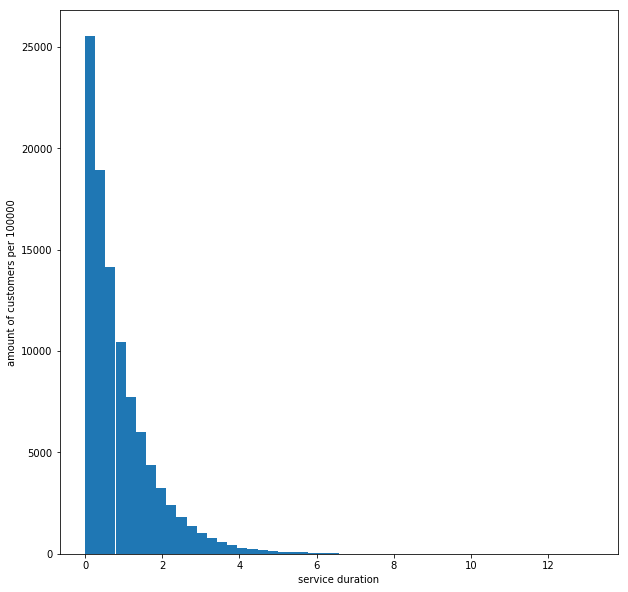

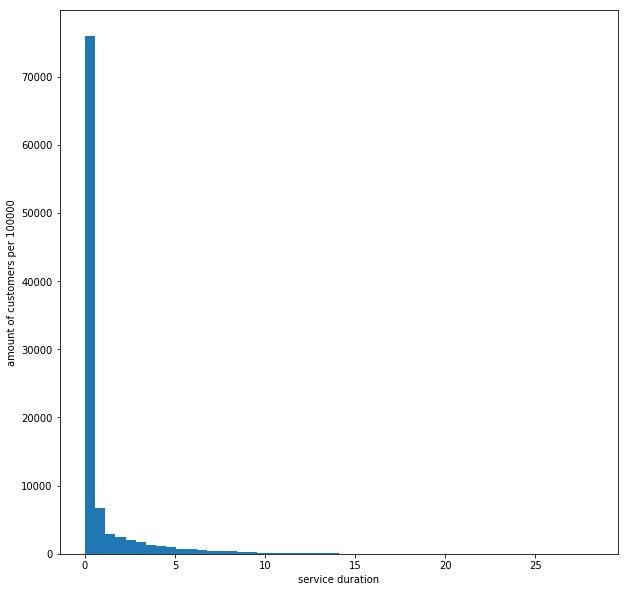

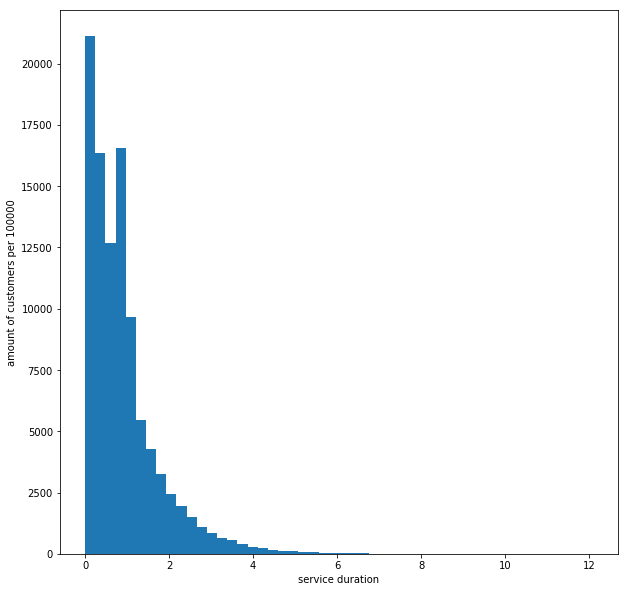

In [32]:
"""
Plot different distribution options
"""
import numpy as np
from matplotlib import pyplot as plt

distributions = ['exponential','long-tail','bimodal']
samples = 100000
mu = 0.9

# exponential distribution
def server_time_exponential():
    server_time = np.random.exponential(mu,1)
    return server_time

# longtail distribution
def server_time_longtail():
    random_number = np.random.random()
    if random_number > 1./4:
        server_time = np.random.exponential(mu/5,1) # mu service time 
    if random_number <= 1./4:
        server_time = np.random.exponential(3.4*mu,1) # mu service time 
    return server_time

# bimodal distribution, with exponential and normal distribution
def server_time_bimodal():
    random_number = np.random.random()
    if random_number > 1./10:
        server_time = np.random.exponential(mu,1)
    if random_number <= 1./10:              
        server_time = [mu + np.random.normal()/10.]
    return server_time 

times = [[],[],[]]
for n in range(samples):
    times[0].append(server_time_exponential()[0])
    times[1].append(server_time_longtail()[0])
    times[2].append(server_time_bimodal()[0])

for distibutionNumber in range(len(times)):
    print 'The mean of the %s distribution is %f' % (distributions[distibutionNumber], np.mean(times[distibutionNumber]))    
    
    plt.figure(figsize=(10,10))
    plt.hist(times[distibutionNumber], 50)
    plt.xlabel('service duration')
    plt.ylabel('amount of customers per %d' % (samples))
    plt.show;

In [17]:
print 'The mean of the %s distribution is %f' % (distributions[distibutionNumber], np.mean(times[distibutionNumber]))

The mean of the bimodal distribution is 0.909570


In [12]:
import math
import numpy as np
print math.e
print math.e**2
print math.e**math.e
print math.e**-1
print math.e**-.1
print math.e**-.01
print math.e**-.000001
print math.e**-0
print math.e**-100
print 
print math.e**1
print math.e**.1
print math.e**.01
print math.e**.000001
print math.e**0
print np.random.exponential(1,1)


2.71828182846
7.38905609893
15.1542622415
0.367879441171
0.904837418036
0.990049833749
0.999999000001
1.0
3.72007597602e-44

2.71828182846
1.10517091808
1.01005016708
1.000001
1.0
[0.11857227]


In [7]:
print np.intp(5)

5
